# SuSiE Pathology Vignette: When Fine-Mapping Goes Wrong

This notebook demonstrates the known "failure modes" of vanilla SuSiE (Sum of Single Effects) regression. While SuSiE is an excellent and fast method for fine-mapping causal variants under sparse assumptions, its reliance on a greedy-style variational approximation (IBSS) can lead to suboptimal solutions in specific LD (Linkage Disequilibrium) scenarios.

We will explore four scenarios:
1.  **The Happy Path:** SuSiE works perfectly.
2.  **Correlated "Bandits":** High correlation makes identification ambiguous, but SuSiE correctly captures uncertainty in Credible Sets.
3.  **Identical Subspaces (Multimodality):** Two distinct sets of variants explain the data equally well. SuSiE finds one and ignores the other.
4.  **The "Ultimate" Greedy Trap:** Marginal associations are misleading (cancellation), leading SuSiE to a local optimum that misses the true signal.

## Setup

First, we load `susieR` and set up some helper functions for simulation. We will simulate genotypes $X \in \{0, 1, 2\}$ (eQTL-like) and center/scale them.

In [51]:
library(susieR)
library(ggplot2)
library(cowplot)
library(Matrix)
library(pheatmap)
options(repr.plot.width = 12, repr.plot.height = 9)

set.seed(1)

# Helper function to plot PIPs
plot_pips <- function(fit, true_causal, title = "SuSiE PIPs") {
  pips <- fit$pip
  df <- data.frame(SNP = 1:length(pips), PIP = pips, 
                   IsCausal = (1:length(pips)) %in% true_causal)
  
  ggplot(df, aes(x = SNP, y = PIP, color = IsCausal)) +
    geom_point(alpha = 0.6) +
    scale_color_manual(values = c("black", "red")) +
    theme_minimal() +
    labs(title = title, x = "SNP Index", y = "Posterior Inclusion Probability")
}

## Scenario 1: The Happy Path

In this scenario, we generate a random $X$ with $N=600, P=10$ (independent columns) and set 3 true causal variants. We compare default SuSiE, warm start at the true triplet, and warm start at a decoy triplet; all should converge to the same high-evidence solution with clean CS recovery.

Simulated PVE: 0.7838698 
Max |corr| (true triplet): 0.6185 
Max |corr| (decoy triplet): 0.0526 
Joint R2 true: 0.8152 | Joint R2 decoy: 0.0054 | PVE_joint_gap (true-decoy): 0.8099 

--- Credible Sets (Default) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   249.4706         1         1        5
2  2   160.2114         1         1        3
3  3   139.0279         1         1        1

--- Credible Sets (True warm start) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   139.0279         1         1        1
2  2   160.2114         1         1        3
3  3   249.4706         1         1        5

--- Credible Sets (Decoy warm start) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   249.4706         1         1        5
2  2   160.2114         1         1        3
3  3   139.0279         1         1        1

ELBO (Default): -691.0922 
ELBO (True warm start): -691.0922 
ELBO (Decoy warm start): -691.0922 
ELBO gap (True - Default): 7.389644e-12 
ELBO gap (Decoy - Defa

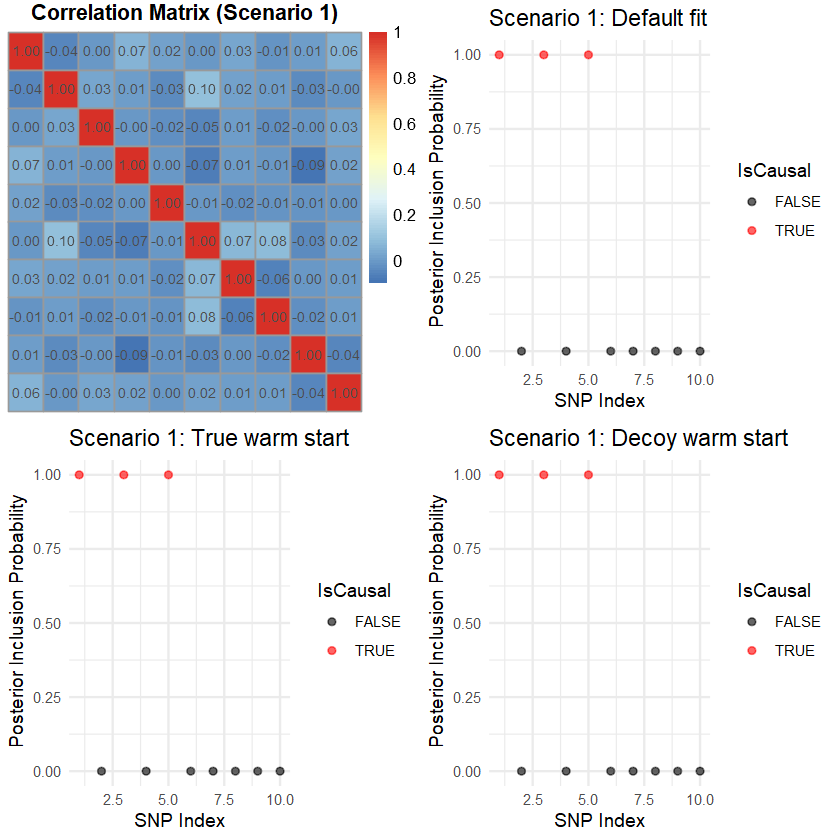

In [52]:
# Scenario 1: The Happy Path
# User Inputs
PVE <- 0.8 # Percentage variance explained (High signal)
N <- 600
P <- 10
L <- 5
set.seed(42)

# Generate independent X
X1 <- matrix(runif(N * P, 0, 1), nrow = N, ncol = P)
X1 <- apply(X1, 2, function(x) scale(rbinom(N, 2, x)))

# True and decoy triplets
true_idx1 <- c(1, 3, 5)
decoy_idx1 <- c(2, 4, 6)

# Simulate y with true effects at 1,3,5
b1 <- rep(0, P)
b1[true_idx1] <- c(0.8, -0.8, 1.0)
g1 <- X1 %*% b1
var_e1 <- var(g1) * (1/PVE - 1)
y1 <- g1 + rnorm(N, sd = sqrt(var_e1))

cat("Simulated PVE:", var(g1)/var(y1), "\n")
cat("Max |corr| (true triplet):", round(max(abs(cor(X1[, true_idx1], y1))), 4), "\n")
cat("Max |corr| (decoy triplet):", round(max(abs(cor(X1[, decoy_idx1], y1))), 4), "\n")
r2_true1 <- summary(lm(y1 ~ X1[, true_idx1]))$r.squared
r2_decoy1 <- summary(lm(y1 ~ X1[, decoy_idx1]))$r.squared
cat("Joint R2 true:", round(r2_true1, 4),
    "| Joint R2 decoy:", round(r2_decoy1, 4),
    "| PVE_joint_gap (true-decoy):", round(r2_true1 - r2_decoy1, 4), "\n")

# Fit SuSiE: default, warm-true, warm-decoy
res1_default <- susie(X1, y1, L = L, estimate_residual_variance = TRUE,
                      estimate_prior_variance = TRUE)
s_init1_true <- list(alpha = matrix(0, nrow = L, ncol = P),
                    mu = matrix(0, nrow = L, ncol = P),
                    mu2 = matrix(0, nrow = L, ncol = P))
class(s_init1_true) <- "susie"
s_init1_true$alpha[cbind(1:3, true_idx1)] <- 1
s_init1_true$mu[cbind(1:3, true_idx1)] <- b1[true_idx1]
s_init1_true$mu2[cbind(1:3, true_idx1)] <- b1[true_idx1]^2
beta1_decoy_init <- as.numeric(coef(lm(y1 ~ X1[, decoy_idx1]))[-1])
beta1_decoy_init <- ifelse(abs(beta1_decoy_init) < 1e-6,
                           sign(beta1_decoy_init + 1e-12) * 1e-6,
                           beta1_decoy_init)
s_init1_decoy <- list(alpha = matrix(0, nrow = L, ncol = P),
                     mu = matrix(0, nrow = L, ncol = P),
                     mu2 = matrix(0, nrow = L, ncol = P))
class(s_init1_decoy) <- "susie"
s_init1_decoy$alpha[cbind(1:3, decoy_idx1)] <- 1
s_init1_decoy$mu[cbind(1:3, decoy_idx1)] <- beta1_decoy_init
s_init1_decoy$mu2[cbind(1:3, decoy_idx1)] <- beta1_decoy_init^2
res1_true <- susie(X1, y1, L = L, s_init = s_init1_true,
                   estimate_residual_variance = TRUE,
                   estimate_prior_variance = TRUE)
res1_decoy <- susie(X1, y1, L = L, s_init = s_init1_decoy,
                    estimate_residual_variance = TRUE,
                    estimate_prior_variance = TRUE)

cat("\n--- Credible Sets (Default) ---\n")
print(summary(res1_default)$cs)
cat("\n--- Credible Sets (True warm start) ---\n")
print(summary(res1_true)$cs)
cat("\n--- Credible Sets (Decoy warm start) ---\n")
print(summary(res1_decoy)$cs)

cat("\nELBO (Default):", susie_get_objective(res1_default), "\n")
cat("ELBO (True warm start):", susie_get_objective(res1_true), "\n")
cat("ELBO (Decoy warm start):", susie_get_objective(res1_decoy), "\n")
cat("ELBO gap (True - Default):", susie_get_objective(res1_true) - susie_get_objective(res1_default), "\n")
cat("ELBO gap (Decoy - Default):", susie_get_objective(res1_decoy) - susie_get_objective(res1_default), "\n")
delta1_true_decoy <- susie_get_objective(res1_true) - susie_get_objective(res1_decoy)
w1_true <- plogis(delta1_true_decoy)
w1_decoy <- 1 - w1_true
cat("Estimated 2-basin ensemble weights (ELBO-softmax):",
    "True =", round(w1_true, 4), "| Decoy =", round(w1_decoy, 4), "\n")

fail1_flag <- (max(res1_default$pip[decoy_idx1]) > max(res1_default$pip[true_idx1])) &&
             (sum(res1_default$pip[decoy_idx1]) > sum(res1_default$pip[true_idx1]))
cat("Default decoy-dominant failure:", fail1_flag, "\n")

# Plot correlations and selections for all three fits
p1_corr <- pheatmap::pheatmap(
  cor(X1),
  display_numbers = TRUE,
  silent = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  main = "Correlation Matrix (Scenario 1)"
)$gtable
p1_default <- plot_pips(res1_default, true_idx1, "Scenario 1: Default fit")
p1_true <- plot_pips(res1_true, true_idx1, "Scenario 1: True warm start")
p1_decoy <- plot_pips(res1_decoy, true_idx1, "Scenario 1: Decoy warm start")
cowplot::plot_grid(p1_corr, p1_default, p1_true, p1_decoy, ncol = 2)

## Scenario 2: Correlated Bandits (Ambiguity)

Here, we simulate 3 causal variants, but for each causal variant, we add a "bandit" (proxy) that is highly correlated ($r \approx 0.9$).

*   **Variables 1 & 2** are proxies
*   **Variables 3 & 4** are proxies
*   **Variables 5 & 6** are proxies

Each pair contains **one causal variant**.

**Expectation:** SuSiE should find 3 CS, but each CS will likely contain **both** variants in the pair. The PIPs for the causal variants will be split between them (e.g., $PIP \approx 0.5$ for each), reflecting genuine uncertainty.

Simulated PVE: 0.1995926 
Max |corr| (true triplet): 0.3309 
Max |corr| (decoy triplet): 0.3253 
Joint R2 true: 0.2493 | Joint R2 decoy: 0.2434 | PVE_joint_gap (true-decoy): 0.0059 

--- Credible Sets (Default) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  2  11.569541 0.9635241 0.9635241      5,6
2  1  17.932095 0.9602324 0.9602324      3,4
3  3   9.348506 0.9576287 0.9576287      1,2

--- Credible Sets (True warm start) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  3  11.569183 0.9635241 0.9635241      5,6
2  2  17.931245 0.9602324 0.9602324      3,4
3  1   9.348758 0.9576287 0.9576287      1,2

--- Credible Sets (Decoy warm start) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  3  11.569284 0.9635241 0.9635241      5,6
2  2  17.931409 0.9602324 0.9602324      3,4
3  1   9.348792 0.9576287 0.9576287      1,2

ELBO (Default): -1580.995 
ELBO (True warm start): -1580.995 
ELBO (Decoy warm start): -1580.995 
ELBO gap (True - Default): -1.537421e-07 
ELBO gap (Decoy - Def

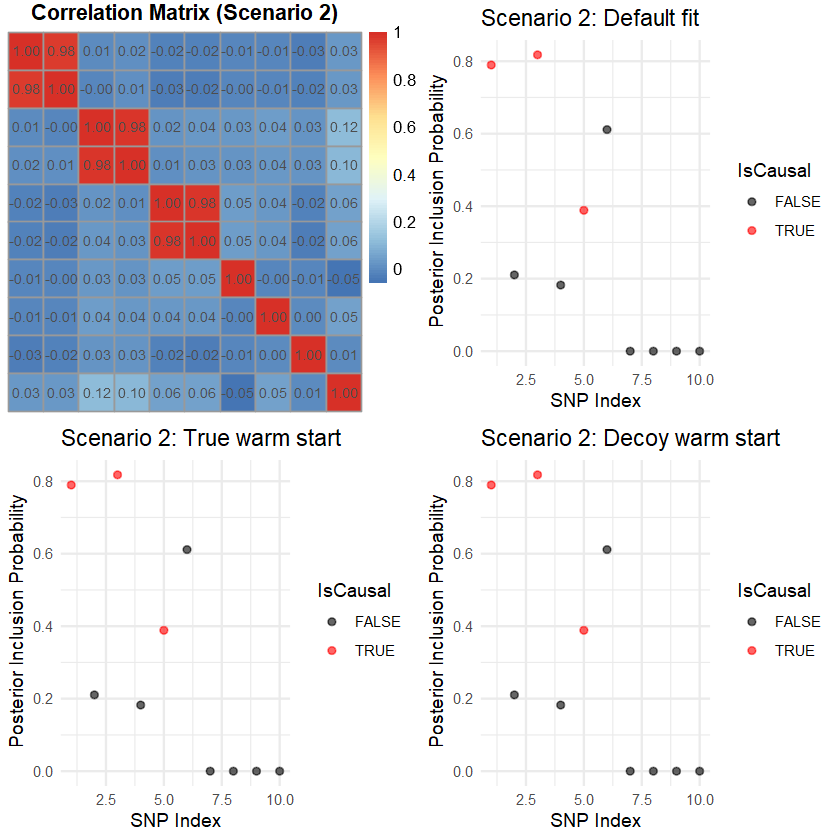

In [53]:
# Scenario 2: Correlated Bandits
# User Inputs
PVE <- 0.2  # Medium signal to encourage ambiguity
N <- 600
P <- 10
L <- 5
set.seed(42)

# Generate X matrix
X2 <- matrix(0, nrow = N, ncol = P)
true_idx2 <- c(1, 3, 5)
decoy_idx2 <- c(2, 4, 6)

for (i in seq(1, 6, 2)) {
  # Generate causal variable (1, 3, 5)
  X2[, i] <- rnorm(N)

  # Generate proxy (Bandit) at i+1 (2, 4, 6)
  rho <- 0.98
  X2[, i + 1] <- rho * X2[, i] + sqrt(1 - rho^2) * rnorm(N)
}

# The rest are noise
X2[, 7:P] <- rnorm(N * (P - 6))
X2 <- scale(X2)

# Simulate y with true effects at 1,3,5
b2 <- rep(0, P)
b2[true_idx2] <- c(1, -1, 1)
g2 <- X2 %*% b2
var_e2 <- var(g2) * (1/PVE - 1)
y2 <- g2 + rnorm(N, sd = sqrt(var_e2))

cat("Simulated PVE:", var(g2)/var(y2), "\n")
cat("Max |corr| (true triplet):", round(max(abs(cor(X2[, true_idx2], y2))), 4), "\n")
cat("Max |corr| (decoy triplet):", round(max(abs(cor(X2[, decoy_idx2], y2))), 4), "\n")
r2_true2 <- summary(lm(y2 ~ X2[, true_idx2]))$r.squared
r2_decoy2 <- summary(lm(y2 ~ X2[, decoy_idx2]))$r.squared
cat("Joint R2 true:", round(r2_true2, 4),
    "| Joint R2 decoy:", round(r2_decoy2, 4),
    "| PVE_joint_gap (true-decoy):", round(r2_true2 - r2_decoy2, 4), "\n")

# Fit SuSiE: default, warm-true, warm-decoy
res2_default <- susie(X2, y2, L = L)
s_init2_true <- list(alpha = matrix(0, nrow = L, ncol = P),
                    mu = matrix(0, nrow = L, ncol = P),
                    mu2 = matrix(0, nrow = L, ncol = P))
class(s_init2_true) <- "susie"
s_init2_true$alpha[cbind(1:3, true_idx2)] <- 1
s_init2_true$mu[cbind(1:3, true_idx2)] <- b2[true_idx2]
s_init2_true$mu2[cbind(1:3, true_idx2)] <- b2[true_idx2]^2
beta2_decoy_init <- as.numeric(coef(lm(y2 ~ X2[, decoy_idx2]))[-1])
beta2_decoy_init <- ifelse(abs(beta2_decoy_init) < 1e-6,
                           sign(beta2_decoy_init + 1e-12) * 1e-6,
                           beta2_decoy_init)
s_init2_decoy <- list(alpha = matrix(0, nrow = L, ncol = P),
                     mu = matrix(0, nrow = L, ncol = P),
                     mu2 = matrix(0, nrow = L, ncol = P))
class(s_init2_decoy) <- "susie"
s_init2_decoy$alpha[cbind(1:3, decoy_idx2)] <- 1
s_init2_decoy$mu[cbind(1:3, decoy_idx2)] <- beta2_decoy_init
s_init2_decoy$mu2[cbind(1:3, decoy_idx2)] <- beta2_decoy_init^2
res2_true <- susie(X2, y2, L = L, s_init = s_init2_true)
res2_decoy <- susie(X2, y2, L = L, s_init = s_init2_decoy)

cat("\n--- Credible Sets (Default) ---\n")
print(summary(res2_default)$cs)
cat("\n--- Credible Sets (True warm start) ---\n")
print(summary(res2_true)$cs)
cat("\n--- Credible Sets (Decoy warm start) ---\n")
print(summary(res2_decoy)$cs)

cat("\nELBO (Default):", susie_get_objective(res2_default), "\n")
cat("ELBO (True warm start):", susie_get_objective(res2_true), "\n")
cat("ELBO (Decoy warm start):", susie_get_objective(res2_decoy), "\n")
cat("ELBO gap (True - Default):", susie_get_objective(res2_true) - susie_get_objective(res2_default), "\n")
cat("ELBO gap (Decoy - Default):", susie_get_objective(res2_decoy) - susie_get_objective(res2_default), "\n")
delta2_true_decoy <- susie_get_objective(res2_true) - susie_get_objective(res2_decoy)
w2_true <- plogis(delta2_true_decoy)
w2_decoy <- 1 - w2_true
cat("Estimated 2-basin ensemble weights (ELBO-softmax):",
    "True =", round(w2_true, 4), "| Decoy =", round(w2_decoy, 4), "\n")

fail2_flag <- (max(res2_default$pip[decoy_idx2]) > max(res2_default$pip[true_idx2])) &&
             (sum(res2_default$pip[decoy_idx2]) > sum(res2_default$pip[true_idx2]))
cat("Default decoy-dominant failure:", fail2_flag, "\n")

# Plot correlations and selections for all three fits
p2_corr <- pheatmap::pheatmap(
  cor(X2),
  display_numbers = TRUE,
  silent = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  main = "Correlation Matrix (Scenario 2)"
)$gtable
p2_default <- plot_pips(res2_default, true_idx2, "Scenario 2: Default fit")
p2_true <- plot_pips(res2_true, true_idx2, "Scenario 2: True warm start")
p2_decoy <- plot_pips(res2_decoy, true_idx2, "Scenario 2: Decoy warm start")
cowplot::plot_grid(p2_corr, p2_default, p2_true, p2_decoy, ncol = 2)

## Scenario 3: Identical Subspaces (Multimodality)

Here, we construct two sets of variables, $A = \{X_1, X_2, X_3\}$ and $B = \{X_4, X_5, X_6\}$, which explain the **same** underlying subspace ($span(A) \approx span(B)$). However, the individual variables are **not** one-to-one correlated (e.g., $X_1$ is not correlated with $X_4$ alone).

SuSiE will typically find only **one** of these sets as a local optimum and ignore the other. This demonstrates how the SuSiE model specification folds the model space into a variational landscape that can only accomodate "singleton bandits" (variants that are non-causal, and get their associative signal entirely from LD with a single causal variant). Pair, triplet, or higher-order bandit variants (groups of non-causal variants which get their associative signal from mixed LD with multiple causal variants) will generally form separate basins in the posterior landscape.

The problem here is that SuSiE can only every commit fully to one basin and will miss equally valid alternatives, potentially leading to overconfidence if only one fit is examined. However, there is a clear solution to this problem: ensembling. We can use warm-starts to nudge SuSiE into fitting both local optima in two separate models, then represent our variant-specific posterior inclusion probabilities (PIPs) as a mixture of the two individual SuSiE model PIPs, using model evidence to set the weights. This way, we can explore the full set of plausible models, and express genuine uncertainty across the full landscape, rather than constraining ourselves to a single optima.

In this scenario, we might naively expect that a proper ensemble would converge to roughly 50/50 weighting between our two optima. Indeed, this is possible, but only under certain settings. Namely:
1. (Simulation setting - Exact) If our A -> B rotation preserves the symmetry of signals (meaning that the vector of equivalent true coefficients is preserved up to index permutation between A and B), then the SuSiE diagnostics will be identical for any SuSiE model settings.
2. (Model setting - Approximate) Even if we do not observe that the A -> B rotation preserves signal symmetry, we can still obtain roughly equal weightings in the long run by setting  `estimate_prior_variance = FALSE`. The added flexibility of estimating variant-specific effect sizes using EB procedure tends to amplify small differences between basins, leading to unstable estimation of between-basin evidence. By removing this procedure, we obtain significantly greater stability in our between basin weights.

**Long-run weights (definition):**
For each seed, fit model A and model B (different initializations), compute softmax ELBO weights
$$w_A = \frac{e^{ELBO_A}}{e^{ELBO_A}+e^{ELBO_B}}, \quad w_B=1-w_A$$
then average these over many seeds. We call those averages the **long-run weights**.

**Empirical finding for this exact setup** ($b_A=(1,-1,0.5)$, fixed $X$, many $y$ seeds):
- `estimate_prior_variance = TRUE` (default): long-run weights are strongly uneven, about **A/B = 0.21/0.79** (500 seeds).
- `estimate_prior_variance = FALSE` with `scaled_prior_variance = 0.2`: weights become much more even, about **A/B = 0.47/0.53** (500 seeds). This setting throttles (reduces) long-run imbalance but does not force exact 50/50.
- `estimate_residual_variance = FALSE` with residual variance fixed to the true simulation value (`var_e3`): imbalance increases again, about **A/B = 0.10/0.90** (120 seeds).
- With **both** prior and residual variances fixed (`estimate_prior_variance = FALSE`, `estimate_residual_variance = FALSE`): about **A/B = 0.26/0.74** (120 seeds).
- **Noiseless check** (`y=g`, no noise), default SuSiE settings: still uneven at about **A/B = 0.23/0.77**.

Below, we lock `estimate_prior_variance = FALSE` for the Scenario 3 demonstration to reduce long-run asymmetry.

**Why this can stay pathological even with milder correlations as $k$ grows:**
For $k$ causal variables, one symmetric same-subspace construction uses
$$Q = I - \frac{2}{k}\mathbf{1}\mathbf{1}^T$$
which gives cross-set correlations
$$\mathrm{corr}(A_i,B_j)=\left(1-\frac{2}{k}\right)\ \text{if } i=j,\quad -\frac{2}{k}\ \text{if } i\neq j$$
So the strongest negative pairwise correlation scales like $-2/k$: as $k$ increases, pairwise correlations can look milder while the two $k$-SNP sets still span essentially the same signal subspace, preserving maximum multimodal ambiguity.

Max abs pairwise correlation in X3: 0.6666667 
Simulated PVE: 0.7081797 
Identified Credible Sets (Standard Fit):
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1  220.50310         1         1        4
2  2   59.12545         1         1        2
--- SuSiE Initialized at A (Expect: 1, 3, 5) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   131.1248         1         1        1
2  2   124.6827         1         1        3
3  3    25.0370         1         1        5

--- SuSiE Initialized at B (Expect: 2, 4, 6) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   59.26187         1         1        2
2  2  220.63784         1         1        4

ELBO (Default Fit): -868.5602 
ELBO (Initialized at A): -868.6959 
ELBO (Initialized at B): -868.5601 
ELBO gap (A - Default): -0.1357297 
ELBO gap (B - Default): 8.327913e-05 
Estimated 2-basin ensemble weights (ELBO-softmax): A = 0.4661 | B = 0.5339 
Default B-dominant mode selection: TRUE 


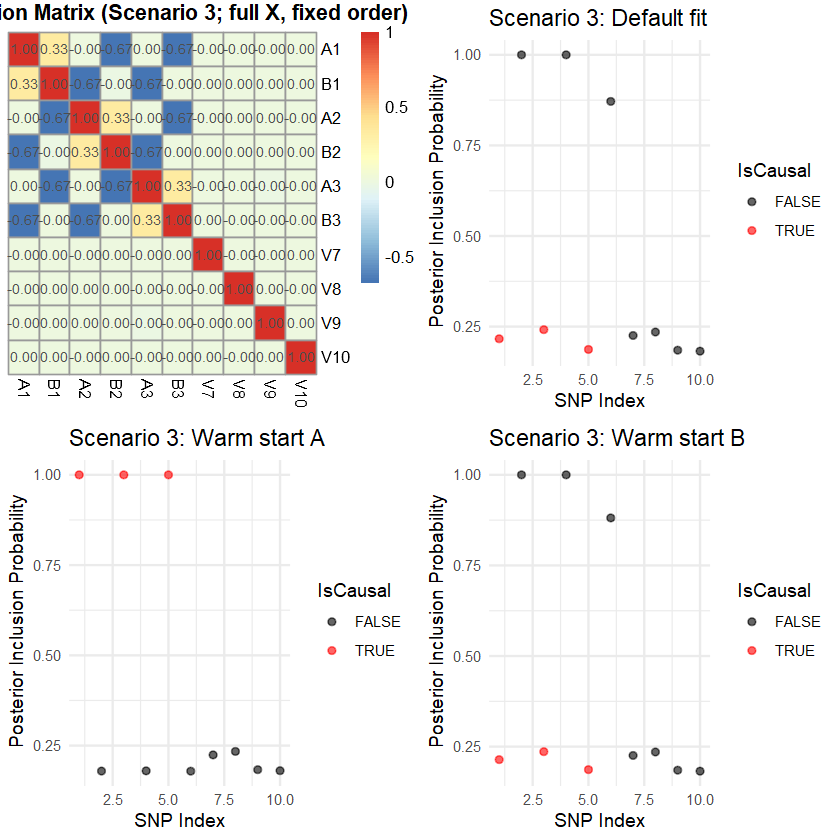

In [54]:
# Scenario 3: Identical Subspaces (Multimodality)
# User Inputs
PVE <- 0.7 # High PVE to make both modes very plausible
N <- 600
P <- 10
set.seed(42)

# This workbook uses susieR only (no susine dependency).


# We want 3 causal vars (Mode A) and 3 alternative vars (Mode B),
# but with minimized max(abs(correlation)) between columns.
#
# Build orthonormal A, then use a minimax 3x3 orthogonal map:
#   Q_opt = I - (2/3) 11^T
# This makes max abs entry ~2/3, near-optimal for 3x3 orthogonal Q.

# 1. Generate orthonormal basis for Mode A (3 vars)
A0 <- scale(matrix(rnorm(N * 3), nrow = N, ncol = 3), center = TRUE, scale = FALSE)
A <- qr.Q(qr(A0))

# 2. Minimax orthogonal transform to create Mode B in same span
Q <- diag(3) - (2/3) * matrix(1, 3, 3)
B <- A %*% Q

# 3. Build noise columns orthogonal to span(A) (and span(B))
Z0 <- scale(matrix(rnorm(N * 4), nrow = N, ncol = 4), center = TRUE, scale = FALSE)
Z0 <- Z0 - A %*% (t(A) %*% Z0)
Z <- qr.Q(qr(Z0))

# 4. Construct X with interleaved A/B pairs and orthogonal noise
X3 <- cbind(A[, 1], B[, 1], A[, 2], B[, 2], A[, 3], B[, 3], Z)
colnames(X3) <- c("A1", "B1", "A2", "B2", "A3", "B3", "V7", "V8", "V9", "V10")
X3 <- scale(X3)

cat("Max abs pairwise correlation in X3:", max(abs(cor(X3)[upper.tri(cor(X3))])), "\n")

# Causal effects on A (cols 1, 3, 5)
b3_A <- c(1, -1, 0.5) 
g3 <- X3[, c(1, 3, 5)] %*% b3_A
var_g3 <- var(g3)
var_e3 <- var_g3 * (1/PVE - 1)

y3 <- g3 + rnorm(N, sd = sqrt(var_e3))

cat("Simulated PVE:", var(g3)/var(y3), "\n")

# Fit SuSiE multiple times (Standard), with fixed prior variance for this tutorial
res3 <- susie(X3, y3, L = 5, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)

cat("Identified Credible Sets (Standard Fit):\n")
print(summary(res3)$cs)

# Plot full X3 correlation matrix (fixed row/column order to keep indices stable)
C3 <- cor(X3)
p3_corr <- pheatmap::pheatmap(
  C3,
  display_numbers = TRUE,
  silent = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  main = "Correlation Matrix (Scenario 3; full X, fixed order)"
)$gtable

# Fit using susie but with FULL initialization (alpha, mu, mu2)
# We need to initialize mu close to truth to prevent it from jumping out.
# True effects for A: 1 (idx 1), -1 (idx 3), 0.5 (idx 5)

# Create base initialization object from previous fit structure
s_init_A <- res3
s_init_A$alpha[] <- 0
s_init_A$mu[] <- 0
s_init_A$mu2[] <- 0

# Set A: indices 1, 3, 5
# Effect 1: variable 1, beta ~ 1
s_init_A$alpha[1, 1] <- 1
s_init_A$mu[1, 1] <- 1
s_init_A$mu2[1, 1] <- 1^2 # approximate

# Effect 2: variable 3, beta ~ -1
s_init_A$alpha[2, 3] <- 1
s_init_A$mu[2, 3] <- -1
s_init_A$mu2[2, 3] <- (-1)^2

# Effect 3: variable 5, beta ~ 0.5
s_init_A$alpha[3, 5] <- 1
s_init_A$mu[3, 5] <- 0.5
s_init_A$mu2[3, 5] <- 0.5^2

# Run susie with full initialization
res3_A_forced <- susie(X3, y3, L = 5, s_init = s_init_A,
                      estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)


# Do the same for Mode B (indices 2, 4, 6)
# B is a rotation of A roughly, so effects might be different in magnitude but exist.
# Since B = A %*% Q, and y ~ A %*% beta, then y ~ B %*% (Q^T %*% beta).
# Let's calculate the theoretical beta for B to give it a fair start.
beta_A <- c(1, -1, 0.5)
# A = B %*% Q^T  => y = A b_A = B Q^T b_A
# So b_B = Q^T b_A
beta_B <- t(Q) %*% beta_A

s_init_B <- res3
s_init_B$alpha[] <- 0
s_init_B$mu[] <- 0
s_init_B$mu2[] <- 0

# Set B: indices 2, 4, 6
# Effect 1 (idx 2)
s_init_B$alpha[1, 2] <- 1
s_init_B$mu[1, 2] <- beta_B[1]
s_init_B$mu2[1, 2] <- beta_B[1]^2

# Effect 2 (idx 4)
s_init_B$alpha[2, 4] <- 1
s_init_B$mu[2, 4] <- beta_B[2]
s_init_B$mu2[2, 4] <- beta_B[2]^2

# Effect 3 (idx 6)
s_init_B$alpha[3, 6] <- 1
s_init_B$mu[3, 6] <- beta_B[3]
s_init_B$mu2[3, 6] <- beta_B[3]^2

# Run susie with full initialization for B
res3_B_forced <- susie(X3, y3, L = 5, s_init = s_init_B,
                      estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)

cat("--- SuSiE Initialized at A (Expect: 1, 3, 5) ---\n")
print(summary(res3_A_forced)$cs)

cat("\n--- SuSiE Initialized at B (Expect: 2, 4, 6) ---\n")
print(summary(res3_B_forced)$cs)


cat("\nELBO (Default Fit):", susie_get_objective(res3), "\n")
cat("ELBO (Initialized at A):", susie_get_objective(res3_A_forced), "\n")
cat("ELBO (Initialized at B):", susie_get_objective(res3_B_forced), "\n")
cat("ELBO gap (A - Default):", susie_get_objective(res3_A_forced) - susie_get_objective(res3), "\n")
cat("ELBO gap (B - Default):", susie_get_objective(res3_B_forced) - susie_get_objective(res3), "\n")
delta3_A_B <- susie_get_objective(res3_A_forced) - susie_get_objective(res3_B_forced)
w3_A <- plogis(delta3_A_B)
w3_B <- 1 - w3_A
cat("Estimated 2-basin ensemble weights (ELBO-softmax):",
    "A =", round(w3_A, 4), "| B =", round(w3_B, 4), "\n")
modeB_flag <- (max(res3$pip[c(2, 4, 6)]) > max(res3$pip[c(1, 3, 5)])) &&
             (sum(res3$pip[c(2, 4, 6)]) > sum(res3$pip[c(1, 3, 5)]))
cat("Default B-dominant mode selection:", modeB_flag, "\n")

# Plot correlations and selections for default + both warm starts
p3_default <- plot_pips(res3, c(1, 3, 5), "Scenario 3: Default fit")
p3_A <- plot_pips(res3_A_forced, c(1, 3, 5), "Scenario 3: Warm start A")
p3_B <- plot_pips(res3_B_forced, c(1, 3, 5), "Scenario 3: Warm start B")
p3_panel <- cowplot::plot_grid(p3_corr, p3_default, p3_A, p3_B, ncol = 2)
print(p3_panel)


## Scenario 4: Greedy Trap (IBSS Pathology)

This scenario is the complement of Scenario 3. In Scenario 3, the key issue was **model-level multimodality** (multiple plausible basins under the same model specification). Here, we focus on a different failure mode: the **greedy IBSS optimizer** itself can get trapped by strong marginals even when a much better joint model exists.

**Goal:** construct data where the true 3-SNP basin has substantially better joint fit than a decoy basin, but default SuSiE still prefers the decoy because of greedy entry via marginals.

**How we construct $X$ and $b$ (locked to config 178):**
1. True triplet: columns $(V1, V3, V5)$ are generated from a shared latent factor (within-triplet correlation controlled by $\rho_{true}=0.8$).
2. True coefficients: $b_{true}=(1.2,-1.8,0.6)$, which creates partial cancellation in marginals but strong joint signal.
3. Decoy triplet: columns $(V2, V4, V6)$ are noisy proxies of the true genetic signal $g_{true}$, designed to have larger marginals than the true set while still having lower joint explanatory power.
4. Remaining columns $(V7\text{--}V10)$ are noise; phenotype is simulated as $y=g_{true}+e$ at target PVE $=0.7$.

We then compare: default fit, warm start at the true basin, and warm start at the decoy basin. We also report a simple two-basin ELBO-softmax estimate of **ensemble weights** for true vs decoy.

Simulated PVE: 0.7161595 
Max |corr| (true triplet): 0.2976 
Max |corr| (decoy triplet): 0.7633 
Joint R2 true: 0.7216 | Joint R2 decoy: 0.5848 | PVE_joint_gap (true-decoy): 0.1368 

--- Credible Sets (Default) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   176.9795         1         1        2

--- Credible Sets (True warm start) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   448.3411         1         1        1
2  2  1033.0484         1         1        3
3  3   124.2752         1         1        5

--- Credible Sets (Decoy warm start) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1    176.969         1         1        2

ELBO (Default): -694.9326 
ELBO (True warm start): -587.0392 
ELBO (Decoy warm start): -694.9327 
ELBO gap (True - Default): 107.8934 
ELBO gap (Decoy - Default): -4.608262e-05 
Estimated 2-basin ensemble weights (ELBO-softmax): True = 1 | Decoy = 0 
Default decoy-dominant failure: TRUE 


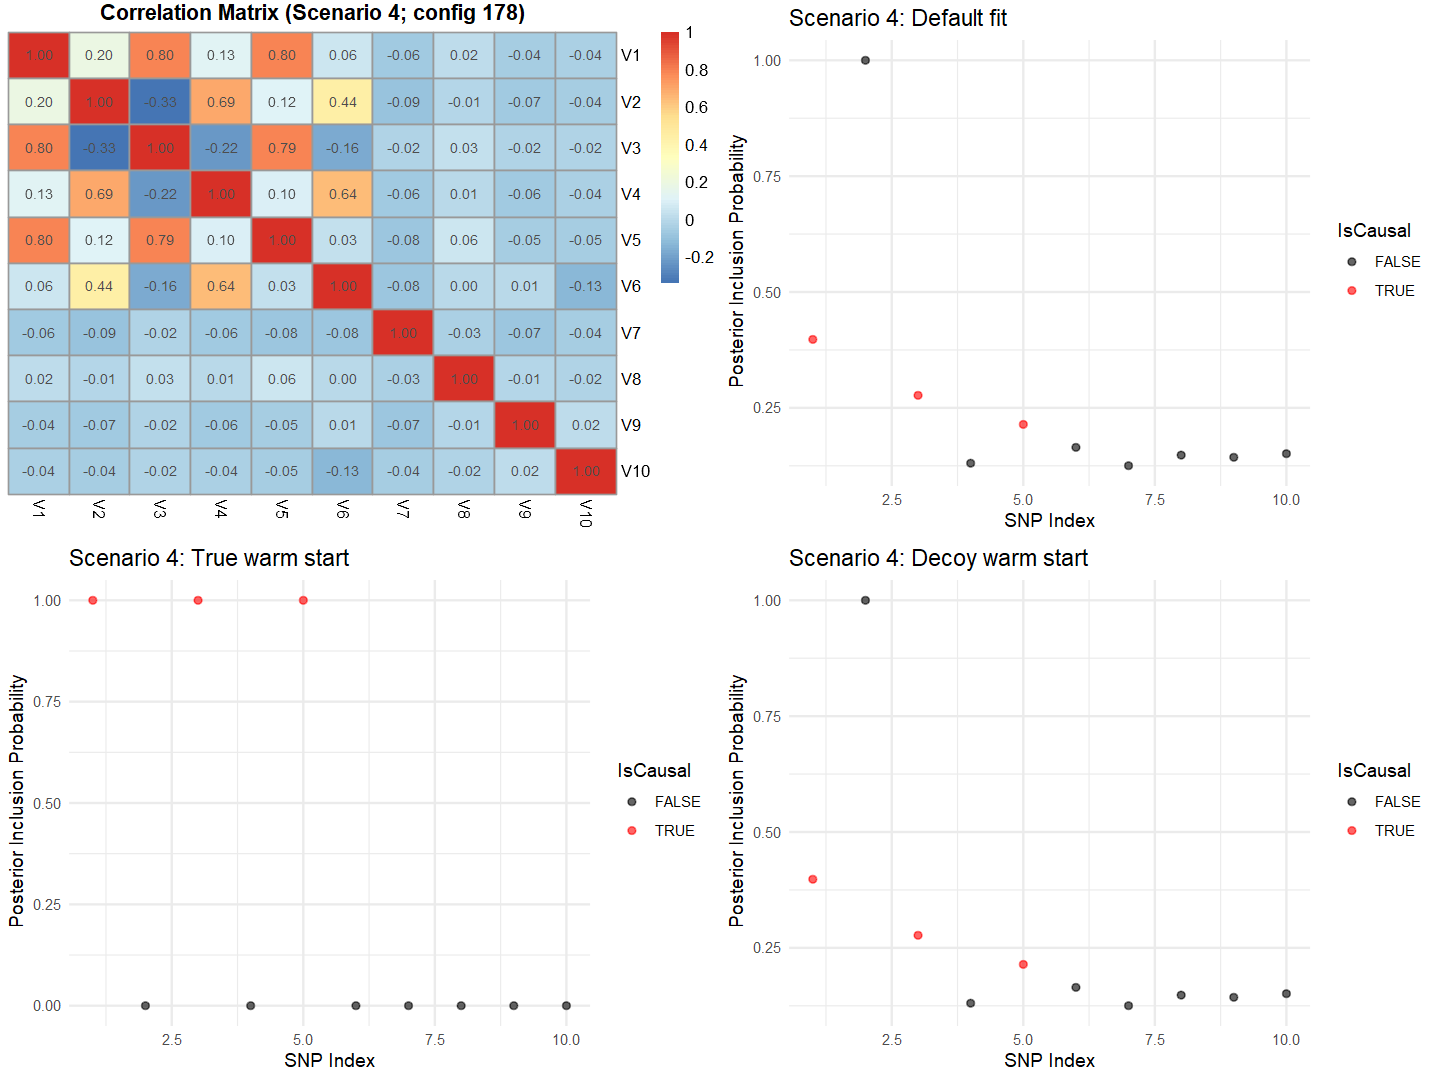

In [56]:
# Scenario 4: Greedy Trap (locked to config_id = 178)
# Keep outputs concise: default fit, true warm start, decoy warm start,
# plus correlation and selection plots.

# User inputs (from search result config_id = 178)
N <- 600
P <- 10
L <- 3
PVE <- 0.70
rho_true <- 0.80
beta_true <- c(1.2, -1.8, 0.6)
d1_noise <- 0.50
d23_noise <- 1.00
set.seed(123)

# True vs decoy index sets (preserve odd causal convention)
true_idx <- c(1, 3, 5)
decoy_idx <- c(2, 4, 6)
noise_idx <- c(7, 8, 9, 10)

# 1) Construct X
f <- rnorm(N)
E <- matrix(rnorm(N * 3), nrow = N, ncol = 3)
X_true <- sqrt(rho_true) * f + sqrt(1 - rho_true) * E
X_true <- scale(X_true)

g_true <- as.numeric(scale(X_true %*% beta_true))
d1 <- as.numeric(scale(g_true + d1_noise * rnorm(N)))
d2 <- as.numeric(scale(d1 + d23_noise * rnorm(N)))
d3 <- as.numeric(scale(d2 + 1.3 * d23_noise * rnorm(N)))

X4 <- matrix(0, nrow = N, ncol = P)
colnames(X4) <- paste0("V", 1:P)
X4[, true_idx] <- X_true
X4[, decoy_idx] <- cbind(d1, d2, d3)
X4[, noise_idx] <- matrix(rnorm(N * length(noise_idx)), nrow = N)
X4 <- scale(X4)

# 2) Simulate y
var_e4 <- var(g_true) * (1/PVE - 1)
y4 <- g_true + rnorm(N, sd = sqrt(var_e4))

cat("Simulated PVE:", var(g_true)/var(y4), "\n")
cat("Max |corr| (true triplet):", round(max(abs(cor(X4[, true_idx], y4))), 4), "\n")
cat("Max |corr| (decoy triplet):", round(max(abs(cor(X4[, decoy_idx], y4))), 4), "\n")
r2_true <- summary(lm(y4 ~ X4[, true_idx]))$r.squared
r2_decoy <- summary(lm(y4 ~ X4[, decoy_idx]))$r.squared
cat("Joint R2 true:", round(r2_true, 4),
    "| Joint R2 decoy:", round(r2_decoy, 4),
    "| PVE_joint_gap (true-decoy):", round(r2_true - r2_decoy, 4), "\n")

# 3) Fit SuSiE: default, true-warm, decoy-warm
res4_default <- susie(X4, y4, L = L, max_iter = 200)
s_init_true <- susie_init_coef(true_idx, beta_true, p = P)
beta_decoy_init <- as.numeric(coef(lm(y4 ~ X4[, decoy_idx]))[-1])
beta_decoy_init <- ifelse(abs(beta_decoy_init) < 1e-6,
                         sign(beta_decoy_init + 1e-12) * 1e-6,
                         beta_decoy_init)
s_init_decoy <- susie_init_coef(decoy_idx, beta_decoy_init, p = P)
res4_true <- susie(X4, y4, L = L, s_init = s_init_true, max_iter = 200)
res4_decoy <- susie(X4, y4, L = L, s_init = s_init_decoy, max_iter = 200)

# 4) Selection and objective summaries
cat("\n--- Credible Sets (Default) ---\n")
print(summary(res4_default)$cs)
cat("\n--- Credible Sets (True warm start) ---\n")
print(summary(res4_true)$cs)
cat("\n--- Credible Sets (Decoy warm start) ---\n")
print(summary(res4_decoy)$cs)

cat("\nELBO (Default):", susie_get_objective(res4_default), "\n")
cat("ELBO (True warm start):", susie_get_objective(res4_true), "\n")
cat("ELBO (Decoy warm start):", susie_get_objective(res4_decoy), "\n")
cat("ELBO gap (True - Default):", susie_get_objective(res4_true) - susie_get_objective(res4_default), "\n")
cat("ELBO gap (Decoy - Default):", susie_get_objective(res4_decoy) - susie_get_objective(res4_default), "\n")
delta_true_decoy <- susie_get_objective(res4_true) - susie_get_objective(res4_decoy)
w_true <- plogis(delta_true_decoy)
w_decoy <- 1 - w_true
cat("Estimated 2-basin ensemble weights (ELBO-softmax):",
    "True =", round(w_true, 4), "| Decoy =", round(w_decoy, 4), "\n")

fail_flag <- (max(res4_default$pip[decoy_idx]) > max(res4_default$pip[true_idx])) &&
             (sum(res4_default$pip[decoy_idx]) > sum(res4_default$pip[true_idx]))
cat("Default decoy-dominant failure:", fail_flag, "\n")

# 5) Plot correlations and selections
p4_corr <- pheatmap::pheatmap(
  cor(X4),
  display_numbers = TRUE,
  silent = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  main = "Correlation Matrix (Scenario 4; config 178)"
)$gtable
p4_default <- plot_pips(res4_default, true_idx, "Scenario 4: Default fit")
p4_true <- plot_pips(res4_true, true_idx, "Scenario 4: True warm start")
p4_decoy <- plot_pips(res4_decoy, true_idx, "Scenario 4: Decoy warm start")

# Make this 2x2 panel larger for notebook viewing (~70% wider, ~50% taller)
p4_panel <- cowplot::plot_grid(p4_corr, p4_default, p4_true, p4_decoy, ncol = 2)
print(p4_panel)
